## VQLS Resrouce Estimation

In this notebook, we transpile the VQLS circuit to a real quantum hardware and estimate the quantum resource required to run it.

### Prepare the linear system from Chorin's Projection

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
nx = 4              # grid size in x-direction
ny = 4              # grid size in y-direction

Re = 100            # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt =  1             # time step size
itr = 10             # iterations
velocity = 1.0

# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

# Define Laplacian
def Laplacian(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = Laplacian(nx, ny, dxi, dyi)
# L[0,:]=0
L[0,0]=1


# Variable declaration
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))

res_hist_classical = []
for timestep in tqdm(range(itr)):
    
    # u-momentum
    us = u.copy()
    u_old = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)
    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)

    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_old = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)
    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)

    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )


    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    
    R = Rn.T.ravel()
    
    # Prepare linear system for VQLS
    pv = np.linalg.solve(L, R)

    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    p[0, 0] = 0


    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    # Update BCs
    v[imin,:] = 0.0                   # left wall
    v[imax+1,:] = 0.0                 # right wall
    v[:, jmin-1] = -v[:, jmin]        # bottom wall
    v[:, jmax+1] = -v[:, jmax]        # top wall

    u[imin-1, :] = -u[imin, :]        # left wall
    u[imax+1, :] = -u[imax, :]        # right wall
    u[:,imin] = 0                     # bottom wall
    u[:,imax+1] = velocity            # top wall
    
    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist_classical.append(max_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2420.12it/s]


Final Iteration = 10; Residual = 0.0006465359449115832


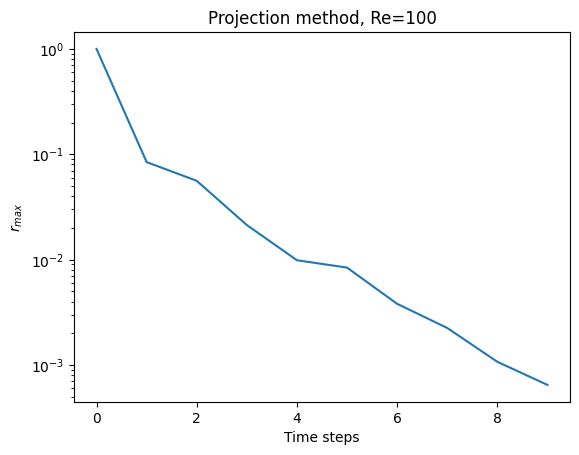

In [2]:
# Final residual        
print(f"Final Iteration = {itr}; Residual = {max_res}")
plt.plot(np.arange(itr), res_hist_classical)
plt.xlabel("Time steps")
plt.ylabel(r"$r_{max}$")
plt.title("Projection method, Re=100")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

In [3]:
# Solve x here 
b = R/np.linalg.norm(R)
x = np.linalg.solve(L, b)
x_norm = np.linalg.norm(x)
x_normalized = x/np.linalg.norm(x)

In [4]:
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, CG, QNSPSA, POWELL
from qiskit_algorithms import optimizers as opt

N = 4        # number of qubits
dim = 2**N   # dimension of the operator 
ref_solution = x_normalized  # setup reference solution 
ansatz = RealAmplitudes(N, entanglement="linear", reps=5, insert_barriers=False)  # build ansatz

# Initialize Qiskit primitives
estimator = Estimator()
sampler = Sampler()

# Initialize VQLS log
log = VQLSLog([], [])

# Build VQLS solver
vqls = VQLS(
    estimator,
    ansatz,
    opt.COBYLA(maxiter=500, disp=True),
    sampler=sampler,
    options={"use_overlap_test": False, 
             "use_local_cost_function": False,
             "matrix_decomposition": "pauli", 
             # "verbose": True
            },
)

In [5]:
_, qc_test = vqls.construct_circuit(L, b)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 3923.55it/s]


Number of circuits: 22


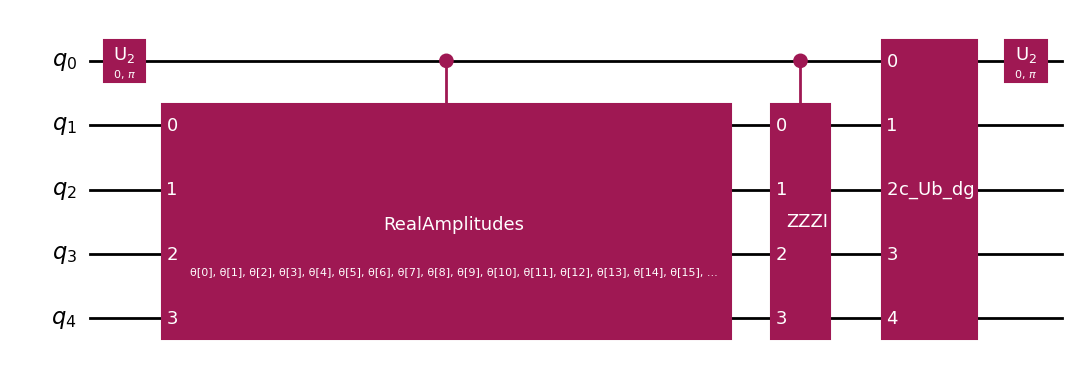

In [6]:
print("Number of circuits:", len(qc_test))
vqls_cir = qc_test[20].circuits[0]

# Note: if not set "matrix_decomposition": "pauli", circuits[0] computes the real part Re<ψ|U|ψ> in Hadamard test
vqls_cir.decompose(reps=1).draw("mpl") 

In [17]:
print("VQLS Circuit depth =", vqls_cir.decompose(reps=4).depth())
print("VQLS gate counts:", vqls_cir.decompose(reps=7).count_ops())

VQLS Circuit depth = 640
VQLS gate counts: OrderedDict([('u', 528), ('cx', 333)])


### Import IBM Account

In [19]:
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Options

# Save your IBM Quantum account on disk.
# QiskitRuntimeService.save_account()

service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')

Or you can import a fake backend with past calibration data.

In [20]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

## Transpile VQLS circuit

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
    # layout_method='sabre',
    # routing_method='sabre',
    seed_transpiler=0
)
ansatz_ibm = pass_manager.run(vqls_cir)

In [22]:
for task in pass_manager.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - ElidePermutations
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation
 - CommutativeCancellation


In [23]:
print("Transpiled VQLS circuit depth on real backend ibm_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on real backend ibm_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on real backend ibm_sherbrooke = 2558
Transpiled VQLS gate counts on real backend ibm_sherbrooke: OrderedDict([('rz', 2249), ('sx', 1411), ('ecr', 480), ('x', 30)])


In [24]:
print("Transpiled VQLS circuit depth on fake backend fake_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on fake backend fake_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on fake backend fake_sherbrooke = 2558
Transpiled VQLS gate counts on fake backend fake_sherbrooke: OrderedDict([('rz', 2249), ('sx', 1411), ('ecr', 480), ('x', 30)])


In [25]:
import numpy as np
from qiskit import schedule

sched = schedule(ansatz_ibm, backend)
print("Transpiled VQLS circuit physical runtime = {:.2f} micro seconds".format(sched.duration*backend.dt*1e6))

t2s = [backend.qubit_properties(n).t2 for n in range(backend.num_qubits)]
print("The averaged coherence time on ibm_sherbrooke T2 = {:.2f} micro seconds".format(np.mean(t2s)*1e6))

Transpiled VQLS circuit physical runtime = 295.98 micro seconds
The averaged coherence time on ibm_sherbrooke T2 = 188.19 micro seconds


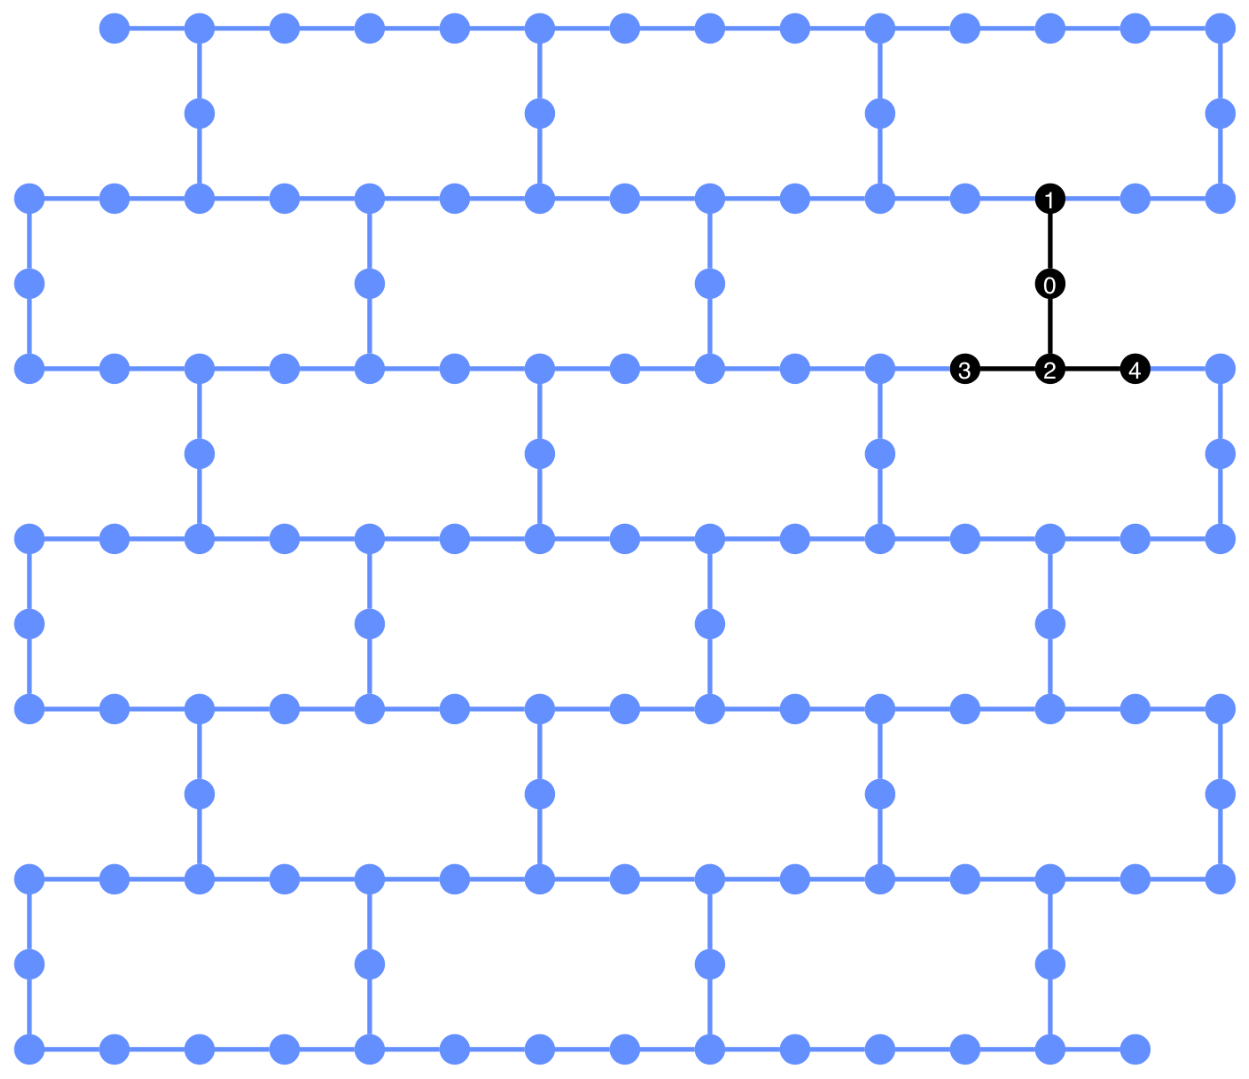

In [26]:
from qiskit.visualization import plot_circuit_layout
display(plot_circuit_layout(ansatz_ibm, backend))

## Software info

In [27]:
import qiskit
import qiskit_ibm_runtime

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')

Qiskit: 1.1.1
Qiskit IBM Runtime: 0.25.0
